In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 1000)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from utils import createXYPlot
from utils import getVariables
from datetime import datetime

today = str(datetime.now().date())
print(today)
plots_folder = f"./plots/{today}/iss"
os.system(f"mkdir -p {plots_folder}")

2022-02-12


0

### Iss data

In [2]:
df_ti = pd.read_csv("./data/rapporti_ISS - TI.csv")
df_decessi = pd.read_csv("./data/rapporti_ISS - Decessi.csv")
df_ricoveri = pd.read_csv("./data/rapporti_ISS - Ricoveri.csv")
df_contagi = pd.read_csv("./data/rapporti_ISS - Contagi.csv")
df_pop = pd.read_csv("./data/rapporti_ISS - Popolazione.csv")

In [3]:
cols_to_select = [x for x in df_pop.columns if "frac" not in x and x != "cut"]
df_pop = df_pop[cols_to_select]
df_pop["data"] = pd.to_datetime(df_pop["data"]).dt.date
df_pop = df_pop.rename(columns={"data":"data_pop"})

In [4]:
df_dict = {
    "contagi": df_contagi,
    "ricoveri": df_ricoveri,
    "terapie_intensive": df_ti, 
    "decessi": df_decessi
}

In [5]:
for d in df_dict.items():
    d[1]["split"] = d[0]

In [6]:
df_iss = pd.concat(df_dict.values()).reset_index(drop=True)
df_iss["tot"] = df_iss["vax"] + df_iss["no_vax"]
df_iss["data"] = pd.to_datetime(df_iss["data"]).dt.date

In [7]:
age_values = df_iss["fascia_eta"].unique()
splits = df_iss["split"].unique()

In [8]:
from datetime import timedelta
df_iss["data_pop"] = df_iss["data"].apply(lambda x: x - timedelta(14))

In [9]:
df_iss = df_iss.merge(df_pop, on=["data_pop","fascia_eta"], how="left", suffixes=("","_pop"))

### Incidence

In [10]:
vnames = ["no_vax", "vax"]
for v in vnames:
    df_iss[f"{v}_100k"] = (1e5)*df_iss[v]/df_iss[f"{v}_pop"]
df_iss["eff"] = 100*(1 - df_iss[f"vax_100k"]/df_iss[f"no_vax_100k"])

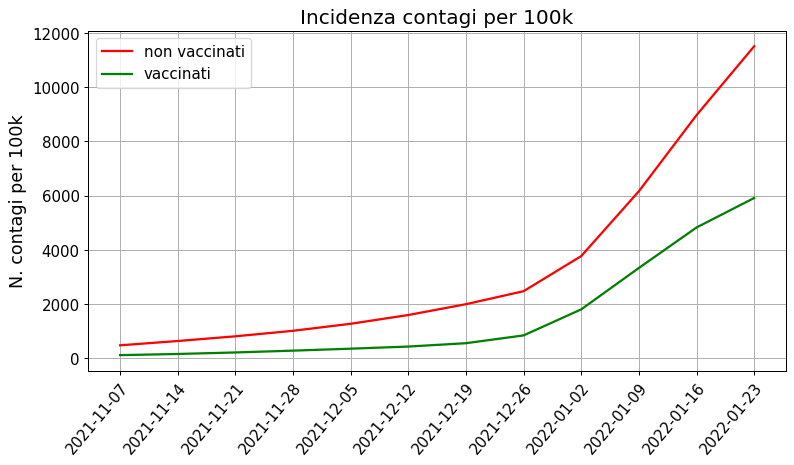

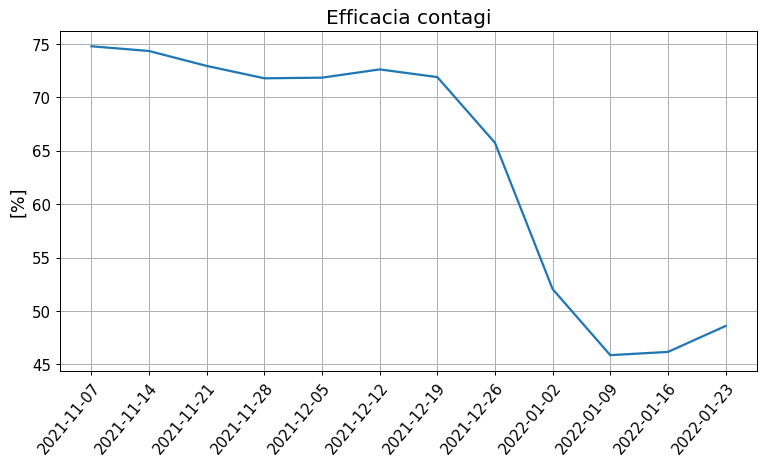

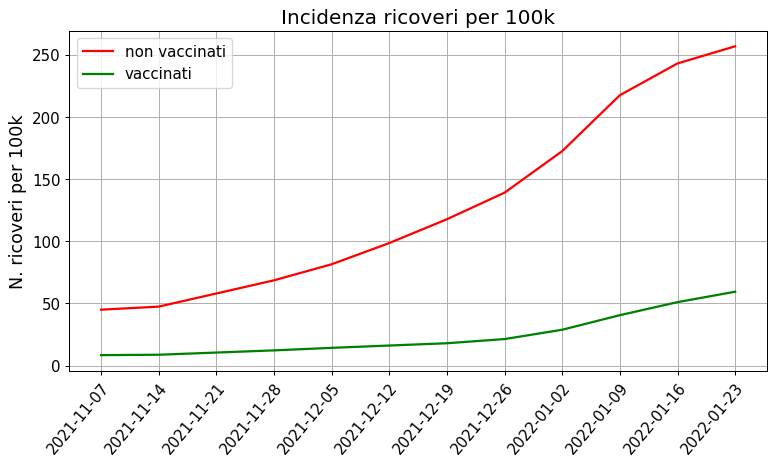

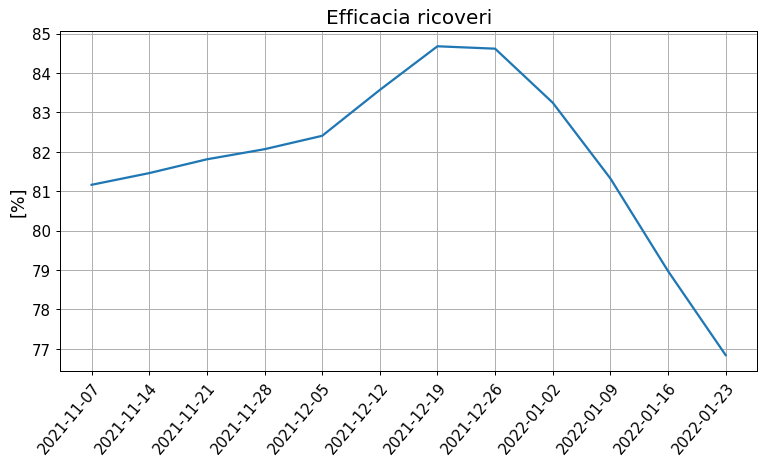

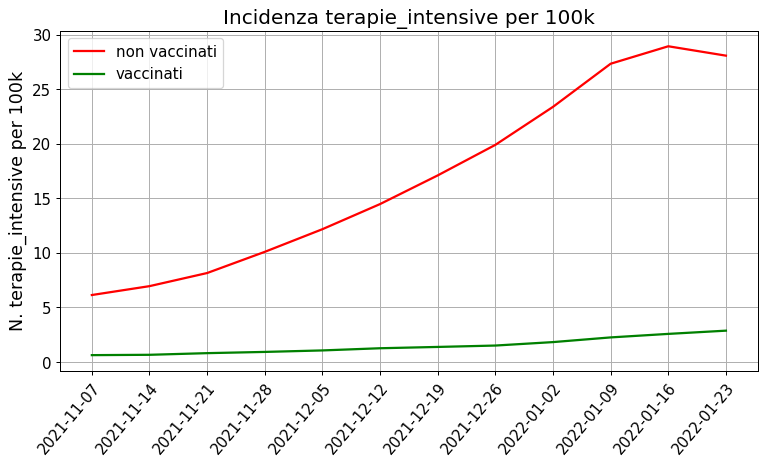

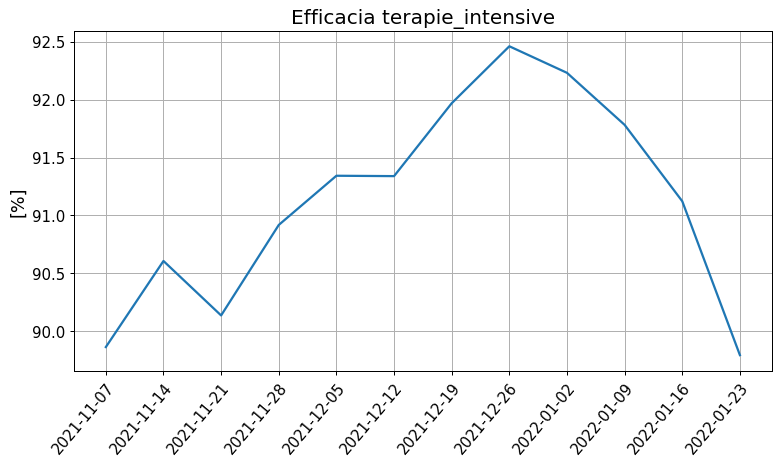

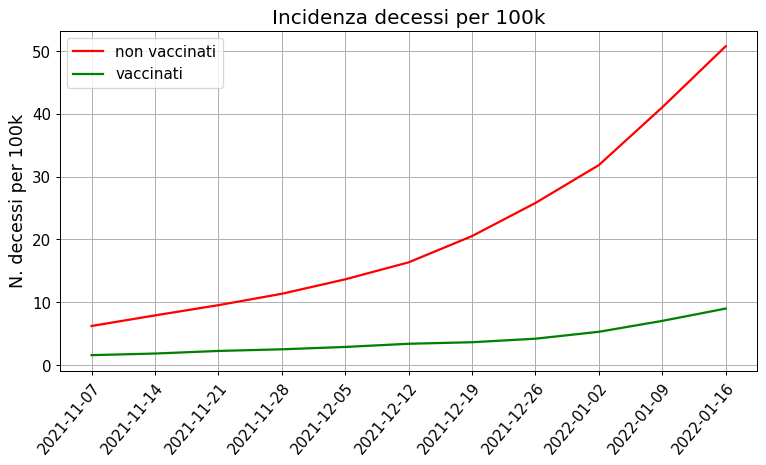

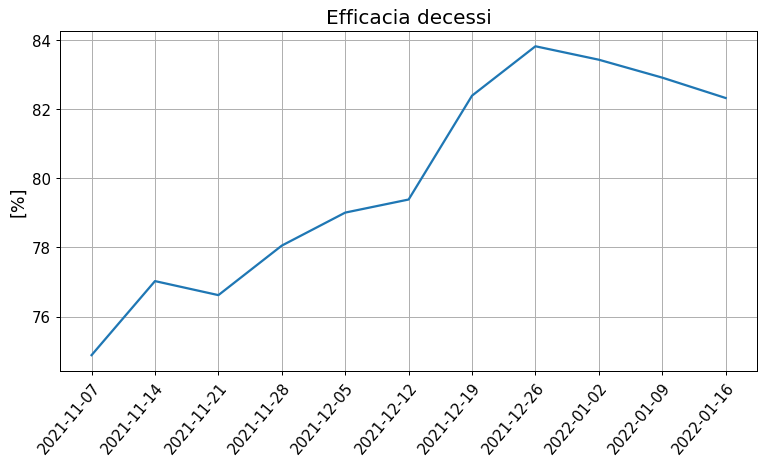

In [11]:
for s in ["contagi","ricoveri","terapie_intensive","decessi"]:
    
    df_plt = df_iss[(df_iss.split==s) & (df_iss.fascia_eta=="totale")]
    #display(df_plt[["data","no_vax_100k","vax_100k"]])
    df_plt = df_plt.dropna()
    vplot = [f"{v}_100k" for v in vnames]
    createXYPlot(df_plt,
                 x="data",
                 y=vplot,
                 colors=["r","g"],
                 labels=["non vaccinati", "vaccinati"],
                 plots_folder=plots_folder,
                 title=f"Incidenza {s} per 100k",
                 figsize_x=10,
                 figsize_y=5,
                 dpis=90,
                 ytitle=f"N. {s} per 100k",
                 savename=f"{s}_per_100k",
                 linewidth=1.8,
                 days_interval=1)
    
    createXYPlot(df_plt,
                 x="data",
                 y=["eff"],
                 plots_folder=plots_folder,
                 title=f"Efficacia {s}",
                 figsize_x=10,
                 figsize_y=5,
                 dpis=90,
                 linewidth=1.8,
                 ytitle="[%]",
                 savename=f"efficacia_{s}",
                 days_interval=1)

In [12]:
#df_iss[["data","fascia_eta","eff","no_vax_pop","vax_pop","split"]]

In [14]:
def plot_vax_vs_no_vax(age: str, 
                       split: str):
    
    plt.figure(dpi=100, figsize=(10,5))
    df_plt = df_iss[(df_iss.fascia_eta==age) & (df_iss.split==split)].reset_index()
    title = f"{split}"
    if age != "totale":
        title += f" {age}"
    createXYPlot(df_plt,
                 y=["no_vax_frac"],
                 labels=["frazione non vaccinati"],
                 colors=["r"],
                 x="data",
                 plots_folder="./plots",
                 days_interval=1,
                 linewidth=1.8,
                 title=title.replace("_"," ")
                )

<Figure size 1000x500 with 0 Axes>

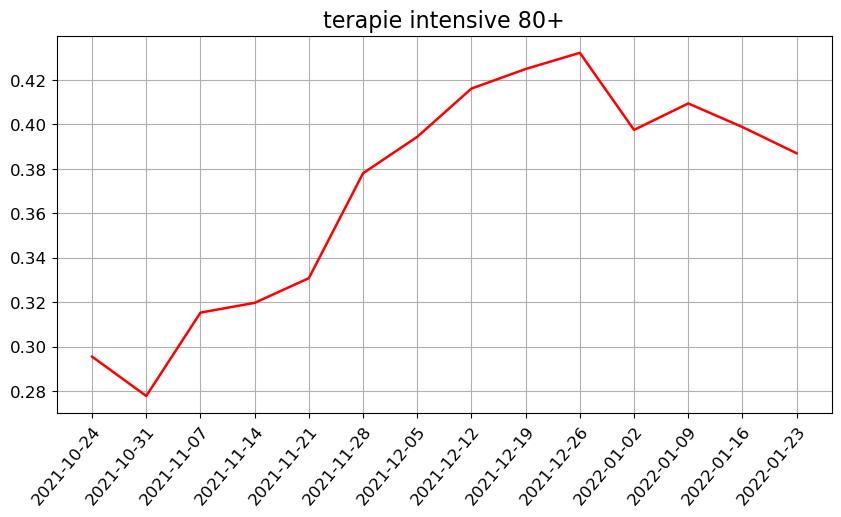

In [15]:
plot_vax_vs_no_vax("80+", "terapie_intensive")

In [16]:
df_iss["no_vax_frac_err"] = 1.645*np.sqrt((df_iss["no_vax_frac"]*df_iss["vax_frac"])/(df_iss["no_vax"] + df_iss["vax"]))
df_iss["no_vax_frac_err_lo"] = df_iss["no_vax_frac"] - df_iss["no_vax_frac_err"]
df_iss["no_vax_frac_err_hi"] = df_iss["no_vax_frac"] + df_iss["no_vax_frac_err"]

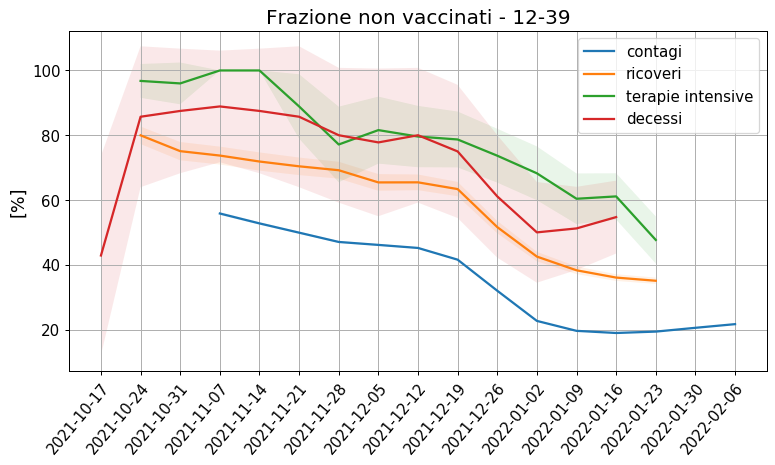

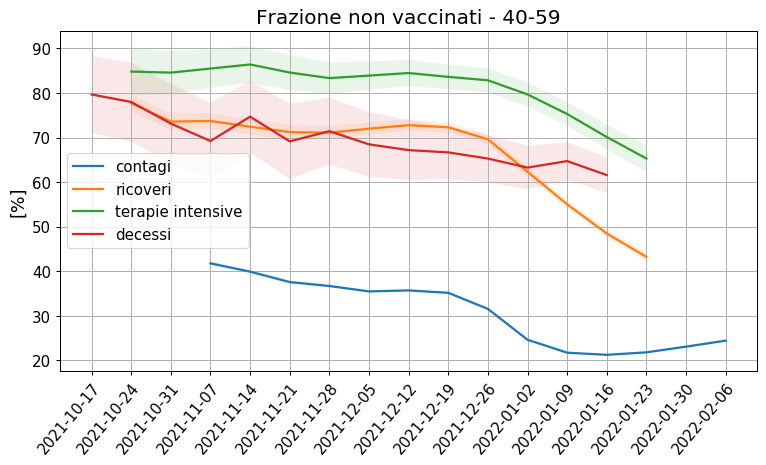

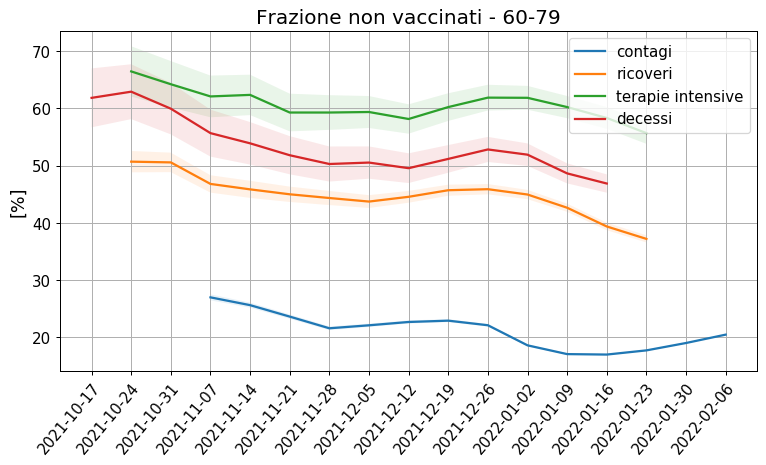

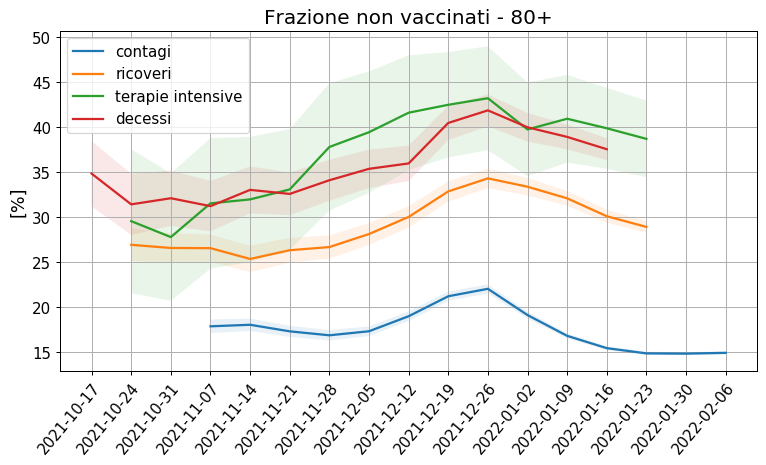

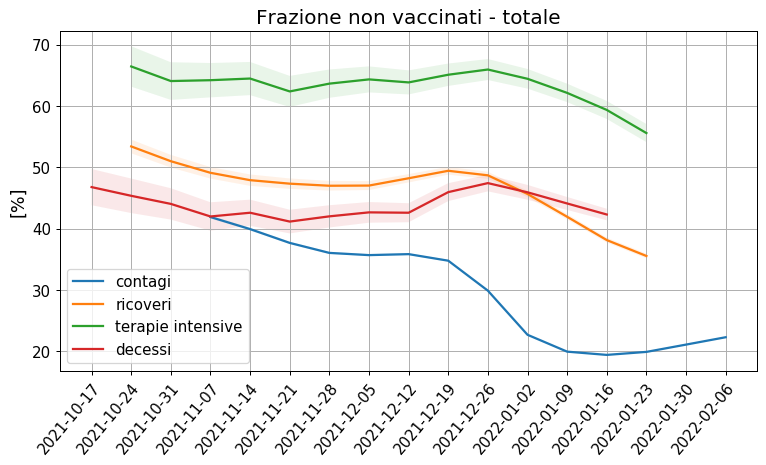

In [28]:
for age in sorted(age_values):
    plt.figure(dpi=90, figsize=(10,5))
    dates_str = []
    dates = []
    for split in ["contagi", "ricoveri", "terapie_intensive", "decessi"]:
        df_plt = df_iss[(df_iss.fascia_eta==age) & (df_iss.split==split)]
        dates_str += [x.strftime("%Y-%m-%d") for x in df_plt.data.unique()]
        dates += [x for x in df_plt.data.unique()]
        plt.plot(df_plt.data,
                 100*df_plt.no_vax_frac,
                 label=split.replace("_"," "),
                 linewidth=1.8
                )
        plt.fill_between(df_plt.data, 
                     100*df_plt.no_vax_frac_err_lo, 
                     100*df_plt.no_vax_frac_err_hi,
                     alpha=0.1
                    )
    title = f"Frazione non vaccinati - {age}"
    plt.title(title, fontsize=16)
    plt.grid()
    plt.legend(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel("[%]",fontsize=14)
    
    dates_str = sorted(list(set(dates_str)), reverse=False)
    dates = sorted(list(set(dates)), reverse=False)
    plt.xticks(dates,
               dates_str,
               fontsize=12,
               rotation=50, 
               rotation_mode="anchor", 
               verticalalignment = "top",
               horizontalalignment = "right")
    plt.savefig(f"{plots_folder}/frazione_no_vax_{age}",bbox_inches="tight")

In [19]:
def plot_var_ages(split, varname="vax"):
    plt.figure(dpi=90, figsize=(10,5))
    for age in sorted(age_values):
        df_plt = df_iss[(df_iss.fascia_eta==age) & (df_iss.split=="terapie_intensive")]
        plt.plot(df_plt.data,
            df_plt[varname],
            label=age,
            linewidth=1.8)
    title = f"Totale {varname} {split}".replace("_", " ")
    plt.title(title, fontsize=16)
    plt.grid()
    plt.legend(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks(df_plt.data,
               fontsize=12,
               rotation=50, 
               rotation_mode="anchor", 
               verticalalignment = "top",
               horizontalalignment = "right"
              )

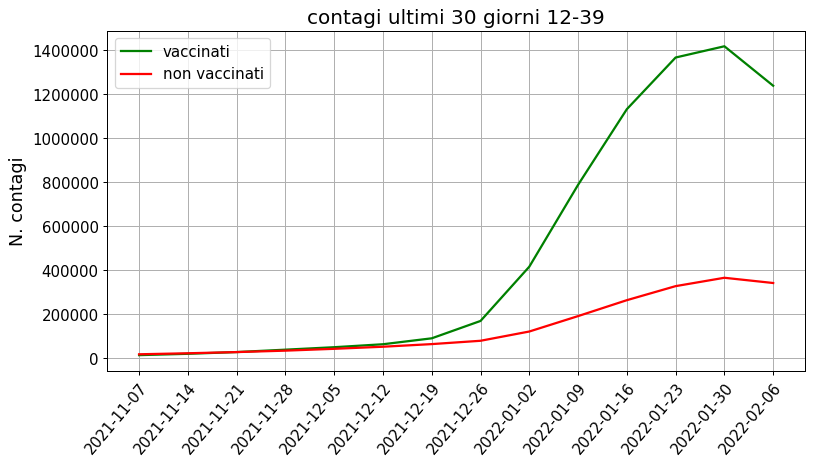

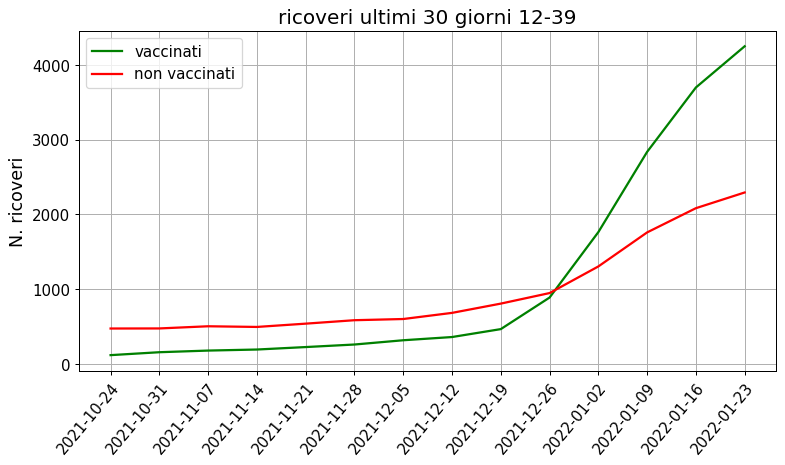

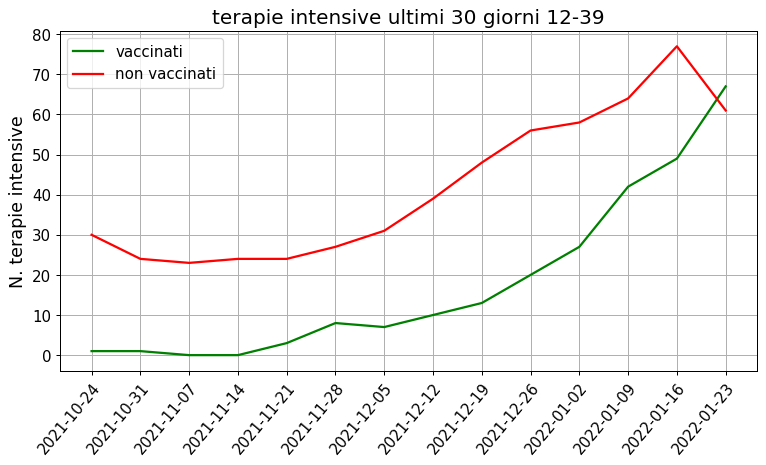

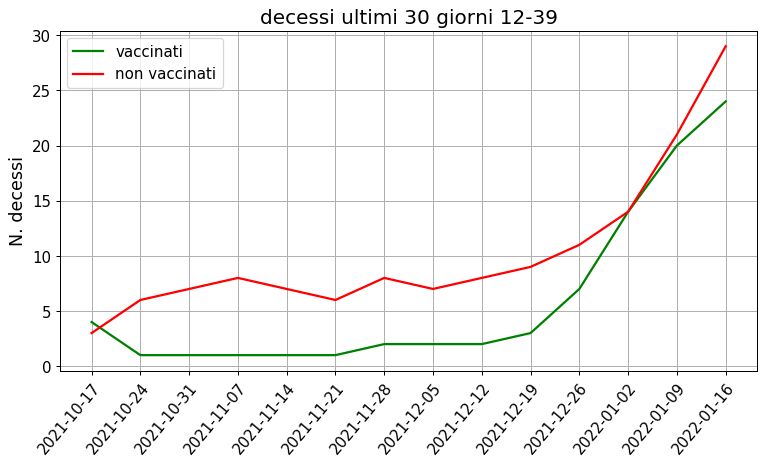

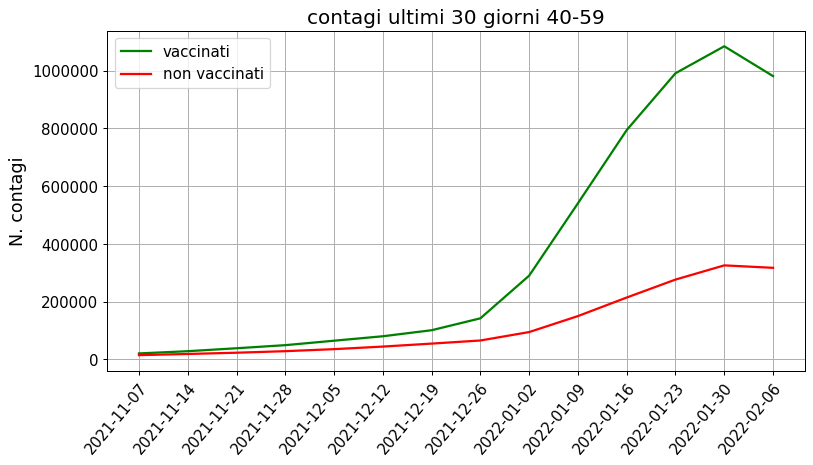

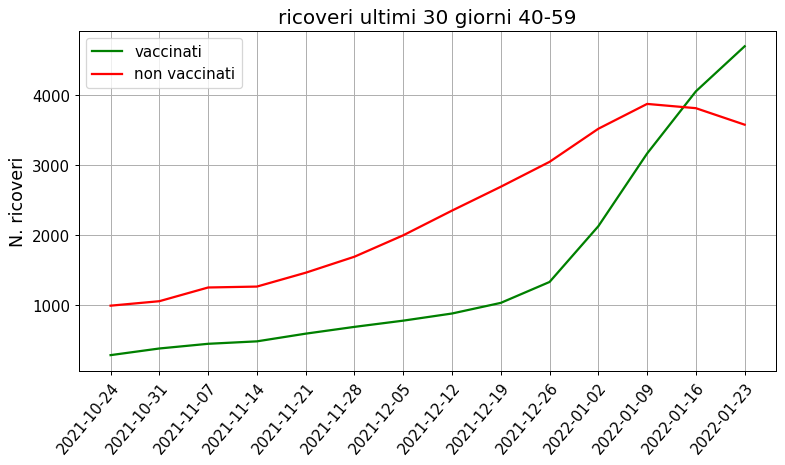

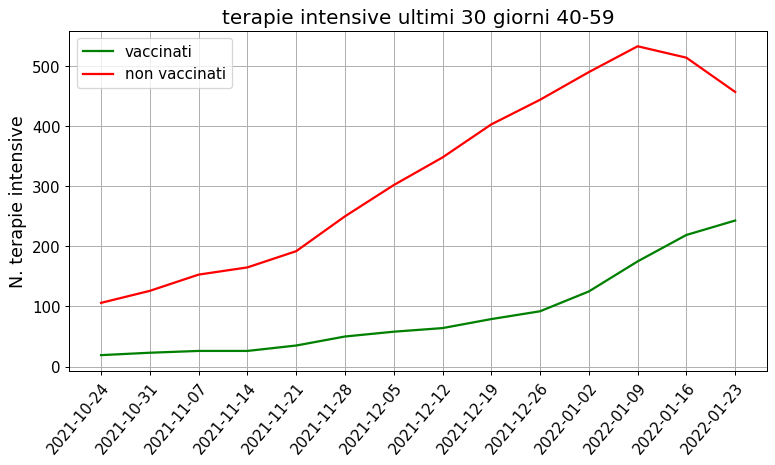

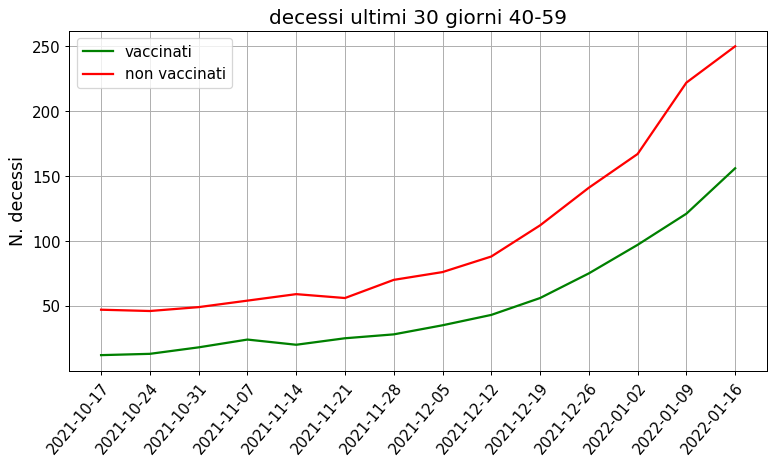

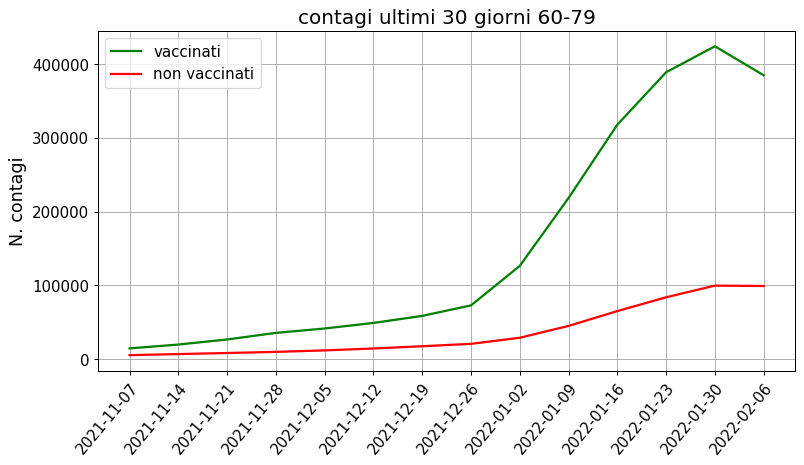

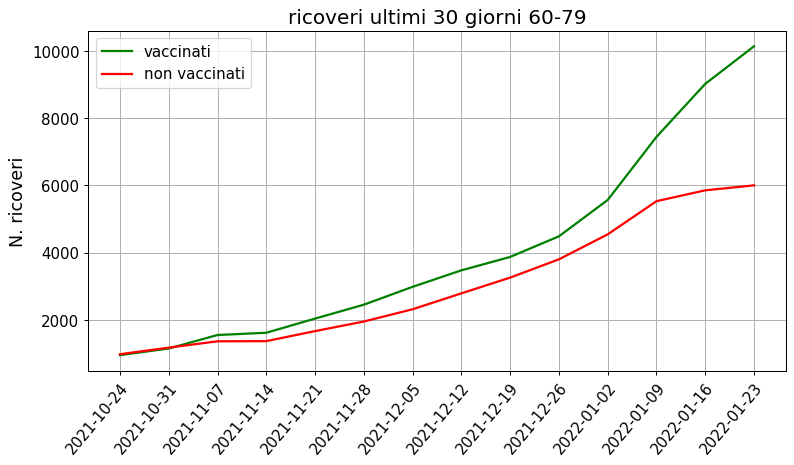

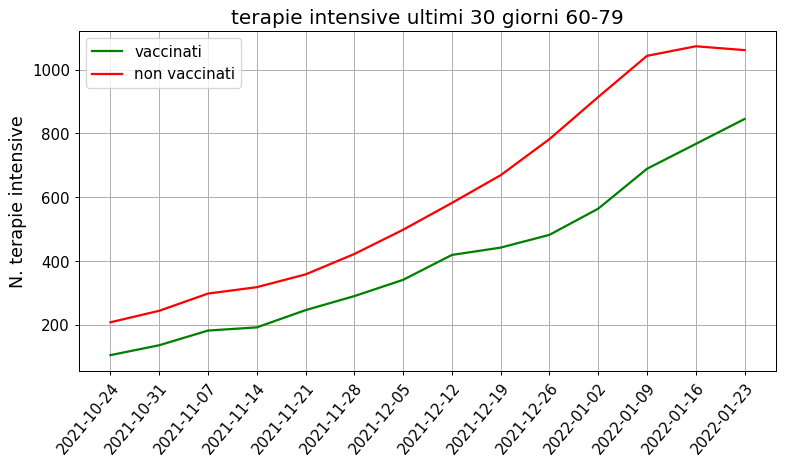

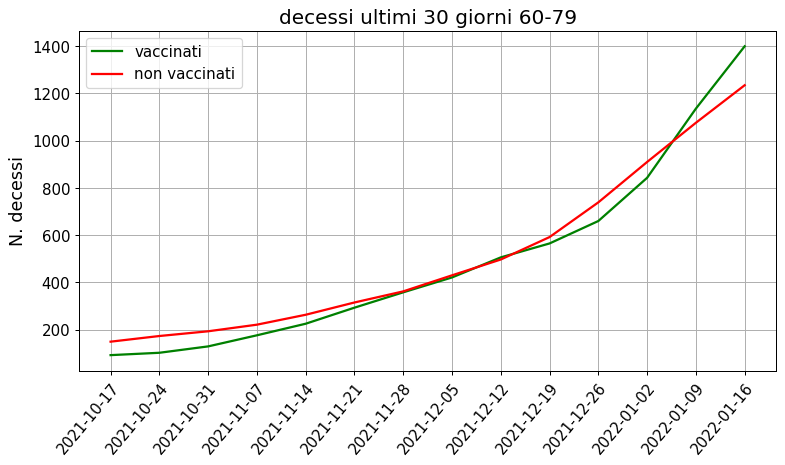

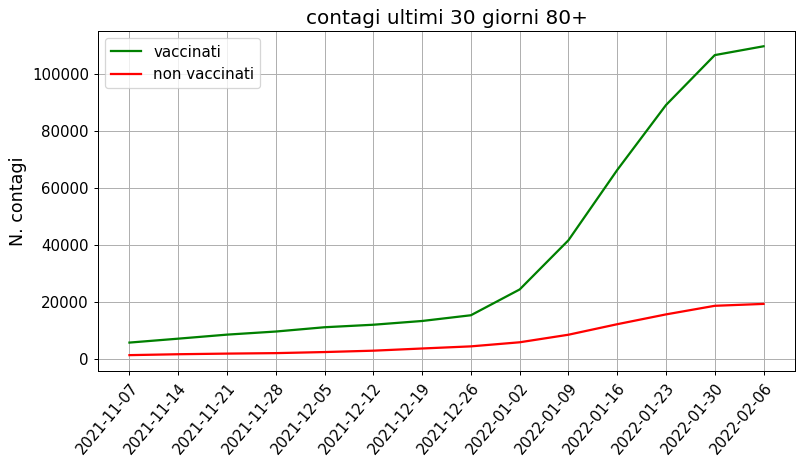

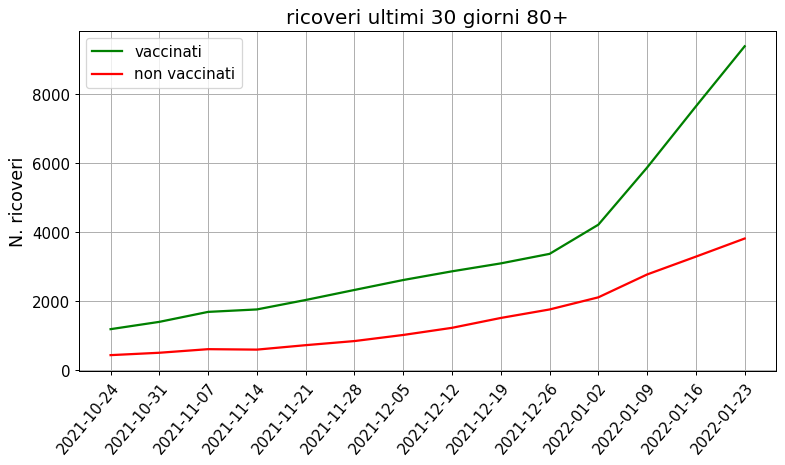

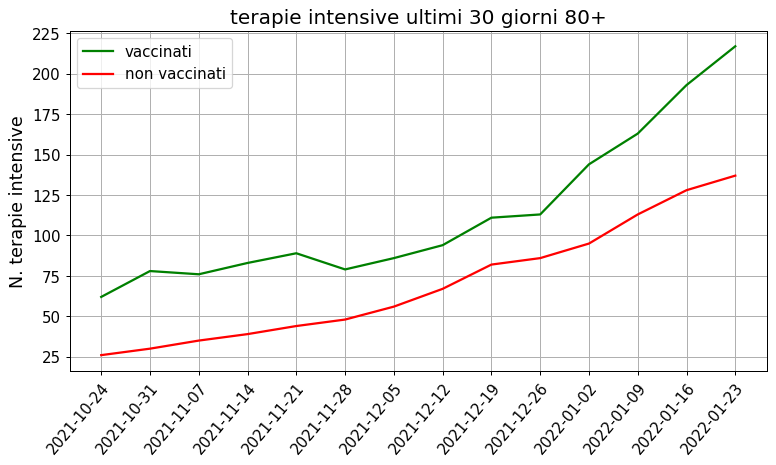

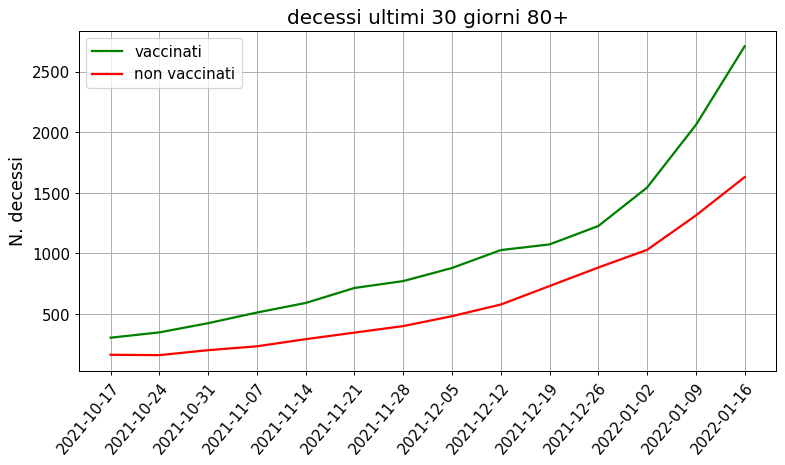

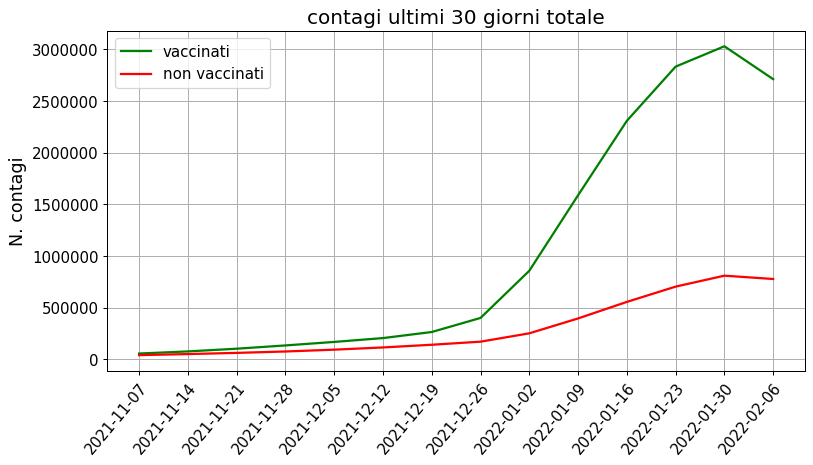

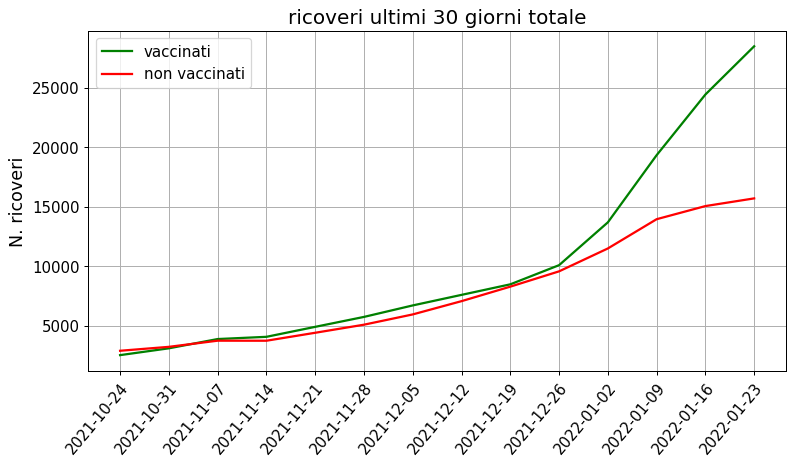

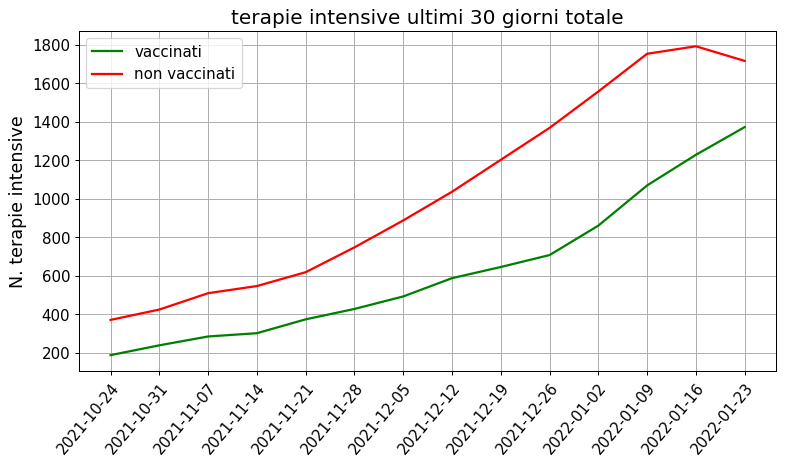

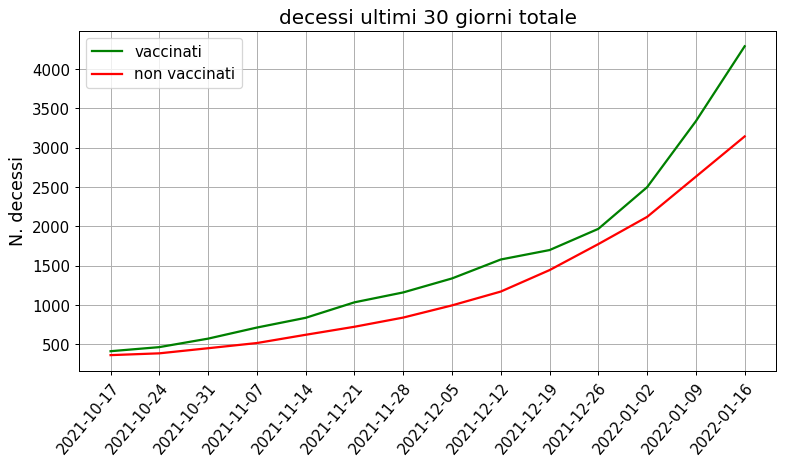

In [20]:
for age in age_values:
    for split in splits:
        df_plt = df_plt = df_iss[(df_iss.fascia_eta==age) & (df_iss.split==split)]
        savename = f"{split}_{age}"
        yvars = ["vax", "no_vax"]
        savename += "_" + "_".join(yvars)
        createXYPlot(df_plt,
                     y=yvars,
                     x="data",
                     labels=["vaccinati", "non vaccinati"],
                     colors=["g","r"],
                     plots_folder=plots_folder,
                     linewidth=1.8,
                     days_interval=1,
                     title=f"{split} ultimi 30 giorni {age}".replace("_"," "),
                     savename=savename,
                     ytitle=f"N. {split}".replace("_"," "),
                     figsize_x=10,
                     figsize_y=5,
                     dpis=90
                    )

In [21]:
def get_lethality(df: pd.DataFrame, 
                  age: str,
                  savename: str,
                  title: str,
                  yscale: str ="linear",
                  num_den: tuple = ("decessi","contagi"),
                 ):

    value_cols = ["vax",
                  "no_vax",
                  "1_dose",
                  "2_dosi_lt_cut",
                  "2_dosi_gt_cut",
                  "booster",
                 ]
    df_pivot = df.pivot(index='data',columns=["split"],values=value_cols)
    cols = []
    for i in range(0,len(df_pivot.columns)):
        cols.append(df_pivot.columns.get_level_values(1)[i] + '_' + df_pivot.columns.get_level_values(0)[i])
    df_pivot.columns = cols
    
    #display(df_pivot)
    for v in value_cols:
        df_pivot[f"letalita_{v}"] = df_pivot[f"{num_den[0]}_{v}"]/df_pivot[f"{num_den[1]}_{v}"]
        df_pivot[f"sd_letalita_{v}"] = np.sqrt(df_pivot[f"letalita_{v}"] * (1 - df_pivot[f"letalita_{v}"]) / df_pivot[f"contagi_{v}"])
        df_pivot[f"lo_err_letalita_{v}"] = df_pivot[f"letalita_{v}"] - 1.645 * df_pivot[f"sd_letalita_{v}"]
        df_pivot[f"hi_err_letalita_{v}"] = df_pivot[f"letalita_{v}"] + 1.645 * df_pivot[f"sd_letalita_{v}"]
        df_pivot[f"lo_err_letalita_{v}"] = df_pivot[f"lo_err_letalita_{v}"].apply(lambda x: 0 if x < 0 else x)
    
    dates = df_pivot[[f"{num_den[0]}_no_vax",f"{num_den[1]}_no_vax"]].dropna().index
    plt.figure(figsize=(10,5),dpi=90)
    for y in ["no_vax", "1_dose", "2_dosi_lt_cut", "2_dosi_gt_cut", "booster"]:
        
        plt.plot(df_pivot.index, 
                 100*df_pivot[f"letalita_{y}"],
                 label=y,
                 linewidth=1.8
                )
        plt.fill_between(df_pivot.index, 
                     100*df_pivot[f"lo_err_letalita_{y}"], 
                     100*df_pivot[f"hi_err_letalita_{y}"],
                     alpha=0.1
                    )
    plt.grid()
    plt.legend(fontsize=12)
    plt.title(f"{title} -- {age} -- dati ISS",fontsize=19)
    plt.ylabel(f"{num_den[0]} / {num_den[1]} [%]",fontsize=14)
    _ = plt.yticks(fontsize=13)
    _ = plt.xticks(dates,
                   fontsize=13,
                   rotation=50, 
                   rotation_mode="anchor", 
                   verticalalignment = "top",
                   horizontalalignment = "right"
                  )
    plt.yscale(yscale)
    plt.savefig(f"{plots_folder}/{savename}.png", bbox_inches="tight")
    return df_pivot

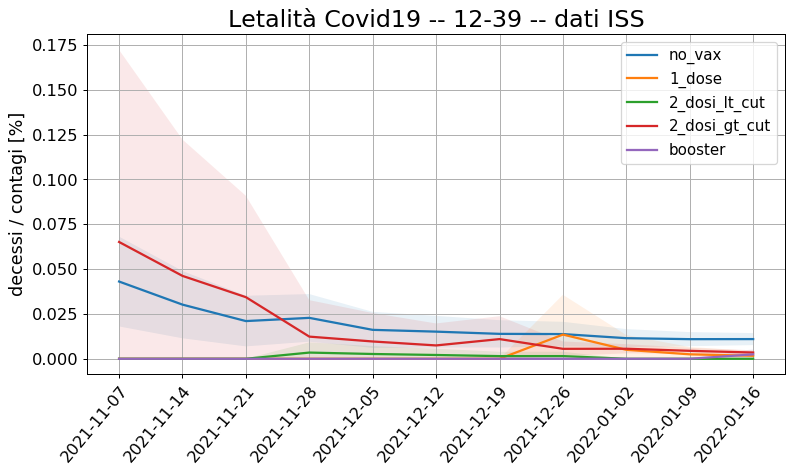

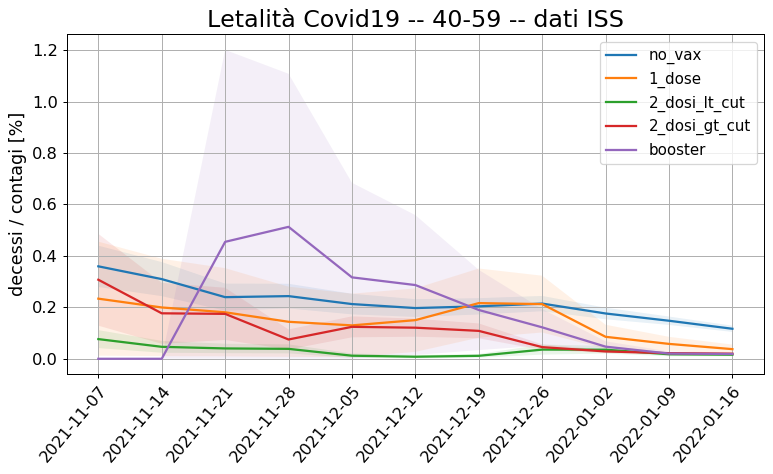

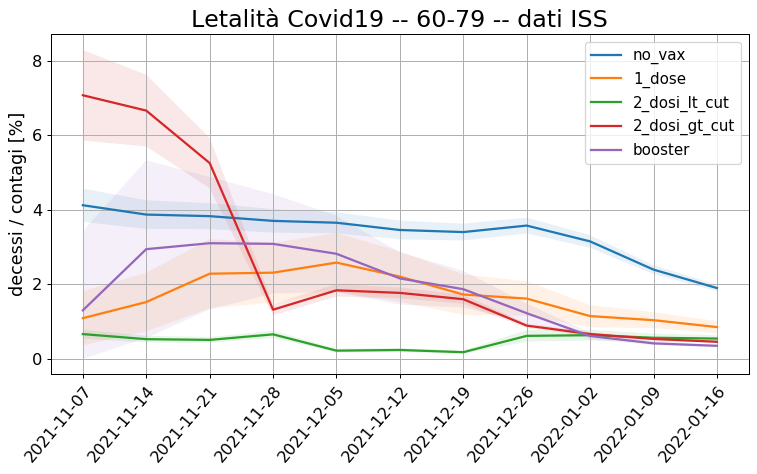

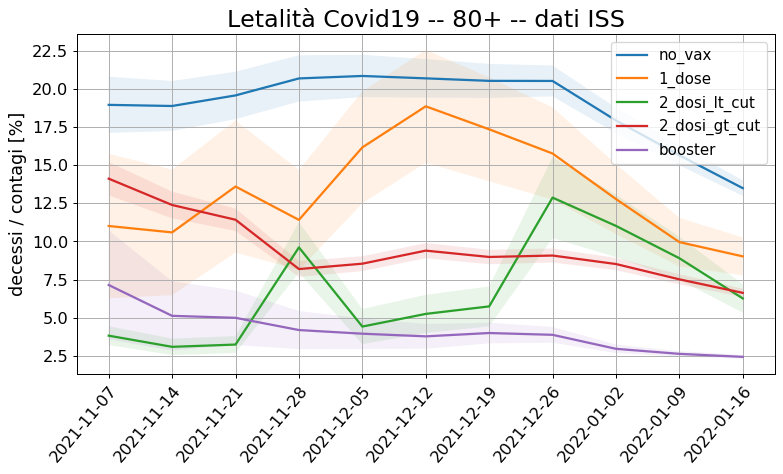

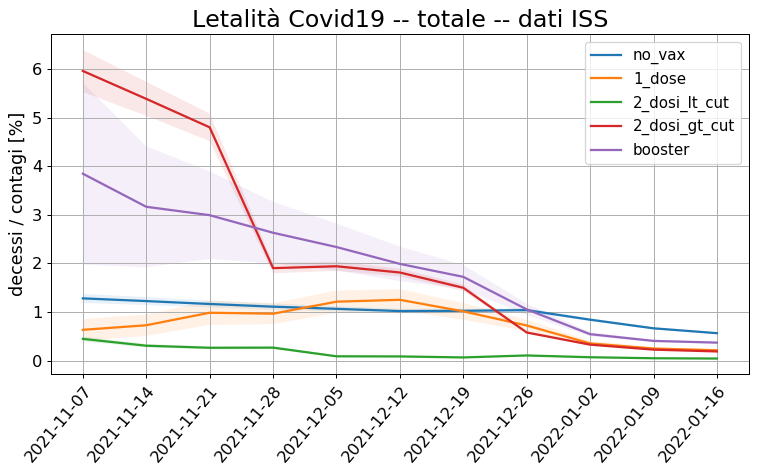

In [22]:
for age in age_values:
    df_let = df_iss[df_iss.fascia_eta==age]
    get_lethality(df_let,
                  age=age,
                  savename=f"letalita_iss_{age}",
                  title="Letalità Covid19",
                  yscale="linear"
                 )

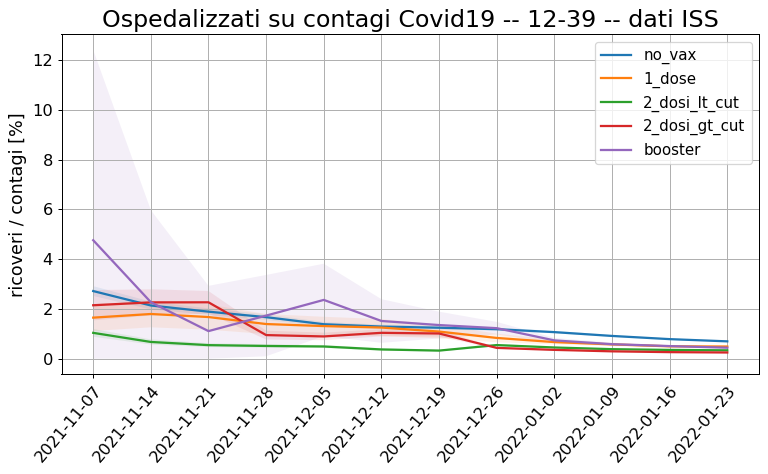

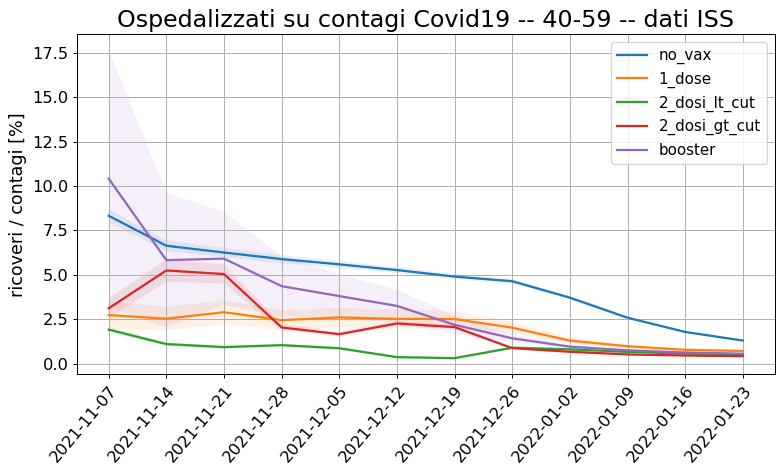

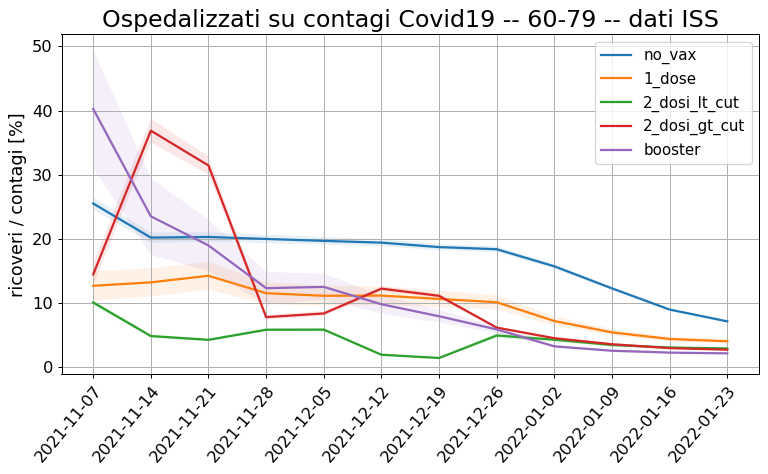

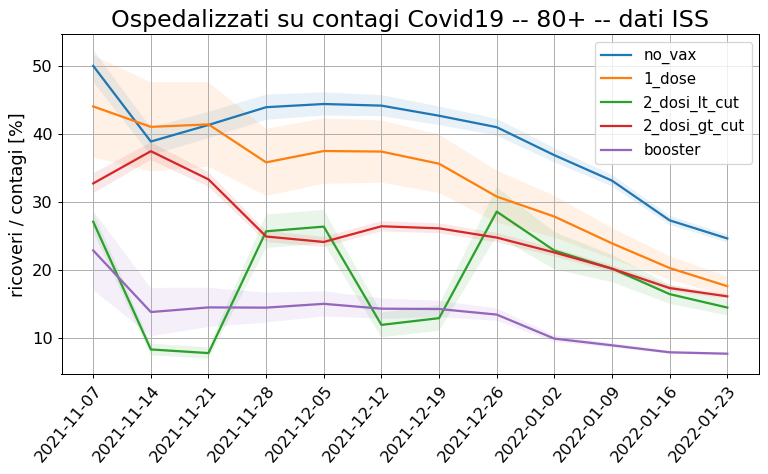

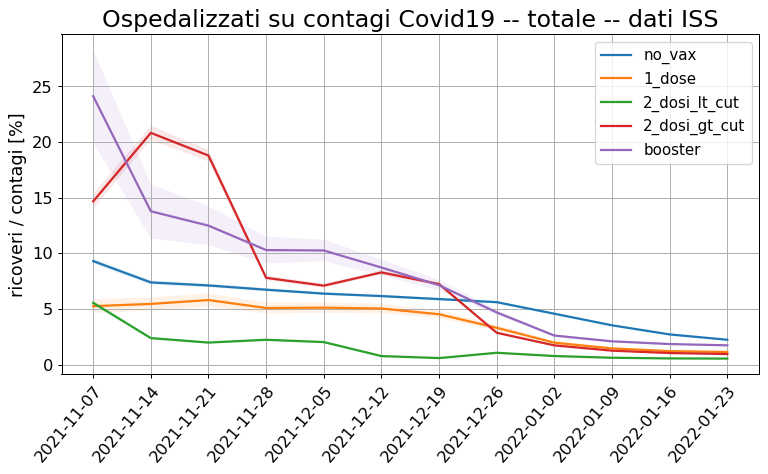

In [23]:
for age in age_values:
    df_let = df_iss[df_iss.fascia_eta==age]
    get_lethality(df_let,
                  age=age,
                  savename=f"ospedalizzati_contagi_iss_{age}",
                  title="Ospedalizzati su contagi Covid19",
                  yscale="linear",
                  num_den=("ricoveri","contagi")
                 )

,contagi_vax,decessi_vax,ricoveri_vax,terapie_intensive_vax,contagi_no_vax,decessi_no_vax,ricoveri_no_vax,terapie_intensive_no_vax,contagi_1_dose,decessi_1_dose,...,ricoveri_2_dosi_lt_cut,terapie_intensive_2_dosi_lt_cut,contagi_2_dosi_gt_cut,decessi_2_dosi_gt_cut,ricoveri_2_dosi_gt_cut,terapie_intensive_2_dosi_gt_cut,contagi_booster,decessi_booster,ricoveri_booster,terapie_intensive_booster
data,,,,,,,,,,,,,,,,,,,,,
2021-10-17,NaN,303.0,NaN,NaN,NaN,162.0,NaN,NaN,NaN,13.0,...,NaN,NaN,NaN,76.0,NaN,NaN,NaN,0.0,NaN,NaN
2021-10-24,NaN,347.0,1192.0,62.0,NaN,159.0,439.0,26.0,NaN,8.0,...,664.0,40.0,NaN,124.0,487.0,21.0,NaN,0.0,6.0,1.0
2021-10-31,NaN,423.0,1404.0,78.0,NaN,200.0,508.0,30.0,NaN,10.0,...,705.0,42.0,NaN,172.0,659.0,34.0,NaN,5.0,15.0,1.0
2021-11-07,5626.0,511.0,1693.0,76.0,1223.0,232.0,612.0,35.0,118.0,13.0,...,710.0,39.0,2747.0,388.0,899.0,35.0,140.0,10.0,32.0,1.0
2021-11-14,7002.0,590.0,1764.0,83.0,1540.0,291.0,599.0,39.0,151.0,16.0,...,228.0,16.0,3840.0,476.0,1439.0,65.0,254.0,13.0,35.0,1.0
2021-11-21,8417.0,714.0,2038.0,89.0,1761.0,345.0,728.0,44.0,169.0,23.0,...,213.0,17.0,5093.0,582.0,1697.0,68.0,401.0,20.0,58.0,2.0
2021-11-28,9505.0,771.0,2329.0,79.0,1927.0,399.0,847.0,48.0,254.0,29.0,...,219.0,13.0,7705.0,631.0,1919.0,64.0,693.0,29.0,100.0,0.0
2021-12-05,11009.0,879.0,2617.0,86.0,2305.0,481.0,1024.0,56.0,272.0,44.0,...,227.0,10.0,8862.0,757.0,2136.0,69.0,1014.0,40.0,152.0,4.0
2021-12-12,11890.0,1027.0,2869.0,94.0,2786.0,577.0,1231.0,67.0,302.0,57.0,...,102.0,6.0,9245.0,869.0,2442.0,79.0,1485.0,56.0,212.0,6.0


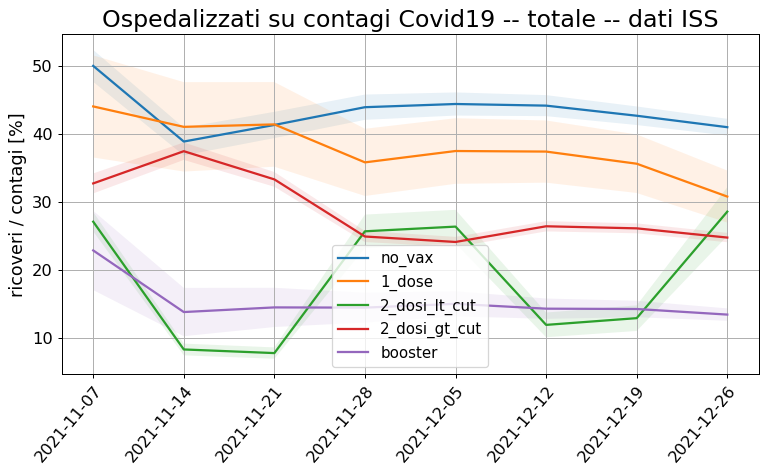

In [92]:
df_let = df_iss[df_iss.fascia_eta=="80+"]
p = get_lethality(df_let,
                  savename=f"ospedalizzati_contagi_iss_{age}",
                  title="Ospedalizzati su contagi Covid19",
                  yscale="linear",
                  num_den=("ricoveri","contagi")
                 )

In [25]:
df_iss["no_vax_last7"] = df_iss["no_vax"] - df_iss.groupby(["fascia_eta","split"])["no_vax"].shift(1)
df_iss["vax_last7"] = df_iss["vax"] - df_iss.groupby(["fascia_eta","split"])["vax"].shift(1)

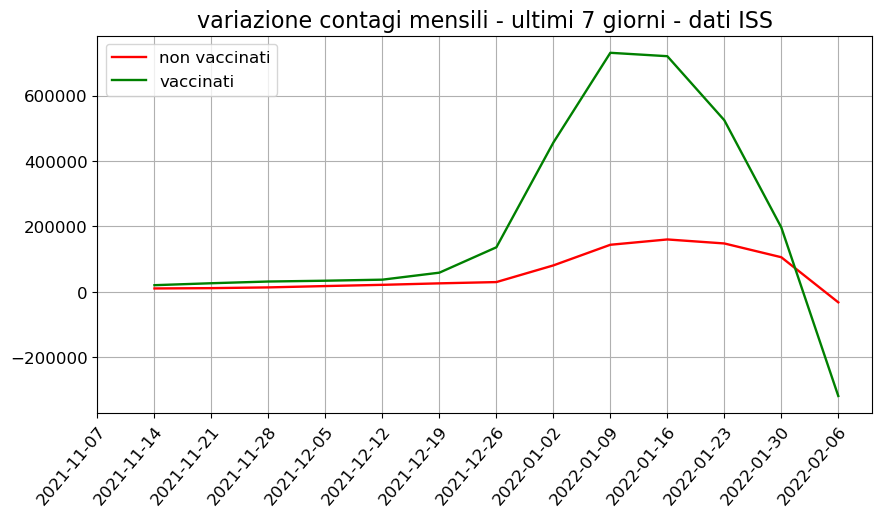

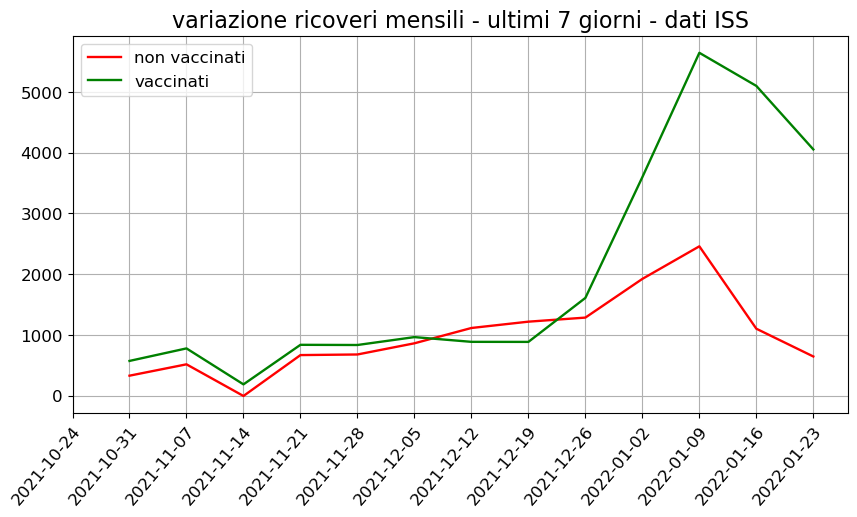

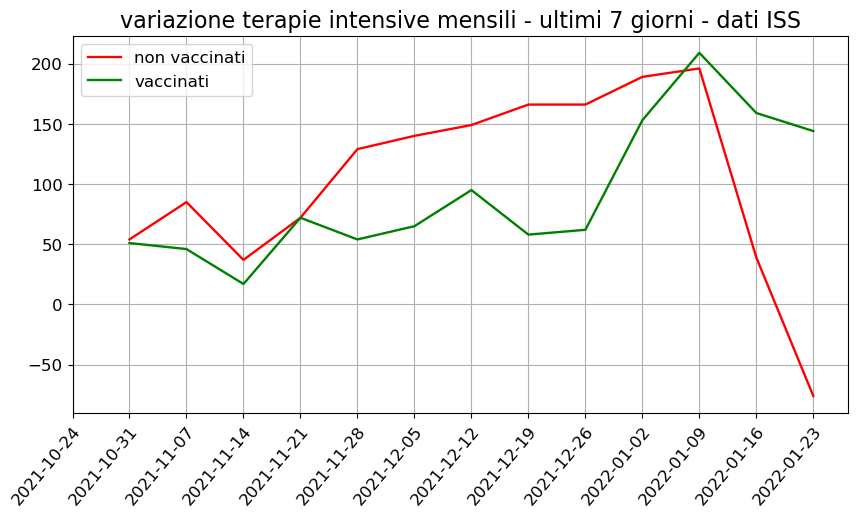

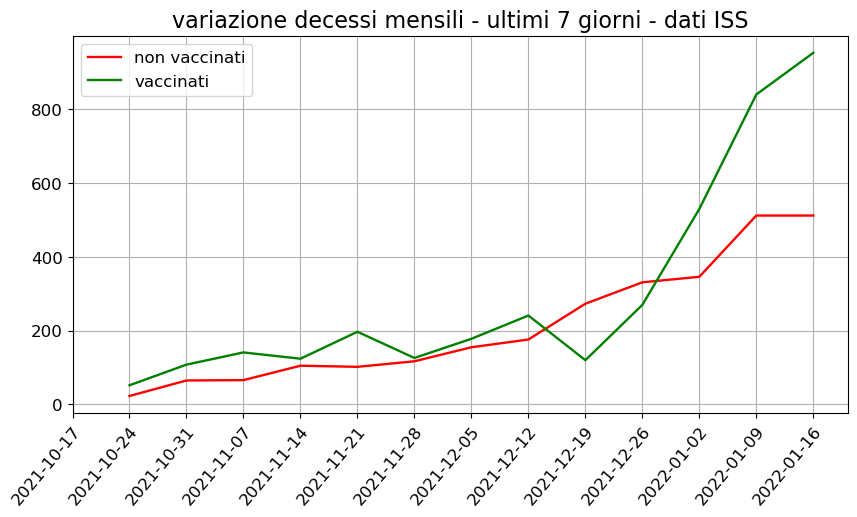

In [27]:
for split in ["contagi", "ricoveri", "terapie_intensive", "decessi"]:
    df_plt = df_iss[(df_iss.fascia_eta=="totale") & (df_iss.split==split)].reset_index()
    createXYPlot(df_plt,
             x="data",
             y=["no_vax_last7","vax_last7"],
             labels=["non vaccinati", "vaccinati"],
             colors=["red","green"],
             linewidth=1.7,
             days_interval=1,
             plots_folder=plots_folder,
             title=f"variazione {split} mensili - ultimi 7 giorni - dati ISS".replace("_"," "),
             savename=f"{split}_ultimi7"
            )

In [27]:
from dateutil.relativedelta import relativedelta
path = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df_daily = getVariables(pd.read_csv(path))


df_daily["data"] = pd.to_datetime(df_daily["data"])
df_daily["data"] = df_daily["data"].apply(lambda x: x.date())
df_daily["data_prev"] = pd.to_datetime("2021-12-10")

In [494]:
df_test = df_daily[(df_daily.data > datetime.strptime("2021-12-10","%Y-%m-%d").date()) & 
         (df_daily.data < datetime.strptime("2022-01-09","%Y-%m-%d").date())][["data","dow","nuovi_positivi"]]

In [495]:
np.sum(df_test["nuovi_positivi"])

2096038

In [500]:
np.sum(df_contagi[df_contagi.fascia_eta=="totale"][["vax","no_vax"]],axis=1)

4       95950
9      126703
14     164396
19     209587
24     261352
29     320068
34     404745
39     570898
44    1108367
49    1983622
dtype: int64

In [489]:
for v in ["ingressi_terapia_intensiva", "nuovi_positivi"]:
    df_daily[f"{v}_last_month"] = df_daily.apply(lambda x: df_daily.loc[(df_daily.data >= x.data_prev) & 
                                                                 (df_daily.data < x.data), v].sum(), axis=1)


In [490]:
df_ti_comp      = df_ti[df_ti.fascia_eta=="totale"][["data","vax","no_vax"]]
df_contagi_comp = df_contagi[df_contagi.fascia_eta=="totale"][["data","vax","no_vax"]]

df_ti_comp["data"] = pd.to_datetime(df_ti_comp["data"]).apply(lambda x: x.date())
df_contagi_comp["data"] = pd.to_datetime(df_contagi_comp["data"]).apply(lambda x: x.date())

df_daily_comp = df_daily[["data","ingressi_terapia_intensiva_last_month","nuovi_positivi_last_month"]]

In [478]:
df_comp_contagi = df_daily_comp.merge(df_contagi_comp, on="data", how="inner")
df_comp_contagi["tot"] = df_comp_contagi["vax"] + df_comp_contagi["no_vax"]
df_comp_contagi["diff"] = df_comp_contagi["tot"] - df_comp_contagi["nuovi_positivi_last_month"] 

,data,nuovi_positivi
655,2021-12-10,20497
656,2021-12-11,21042
657,2021-12-12,19215
658,2021-12-13,12712
659,2021-12-14,20677
660,2021-12-15,23195
661,2021-12-16,26109
662,2021-12-17,28632
663,2021-12-18,28064
664,2021-12-19,24259


In [480]:
df_comp_contagi[["data","nuovi_positivi_last_month","tot","diff"]]

,data,nuovi_positivi_last_month,tot,diff
0,2021-11-07,0,95950,95950
1,2021-11-14,0,126703,126703
2,2021-11-21,0,164396,164396
3,2021-11-28,0,209587,209587
4,2021-12-05,0,261352,261352
5,2021-12-12,41539,320068,278529
6,2021-12-19,200143,404745,204602
7,2021-12-26,457662,570898,113236
8,2022-01-02,1102187,1108367,6180
9,2022-01-09,2116535,1983622,-132913


In [ ]:
df_comp = df_daily_comp.merge(df_ti_comp, on="data", how="inner")
df_comp["tot"] = df_comp["vax"] + df_comp["no_vax"]
df_comp["diff"] = df_comp["tot"] - df_comp["ingressi_terapia_intensiva_last_month"] 

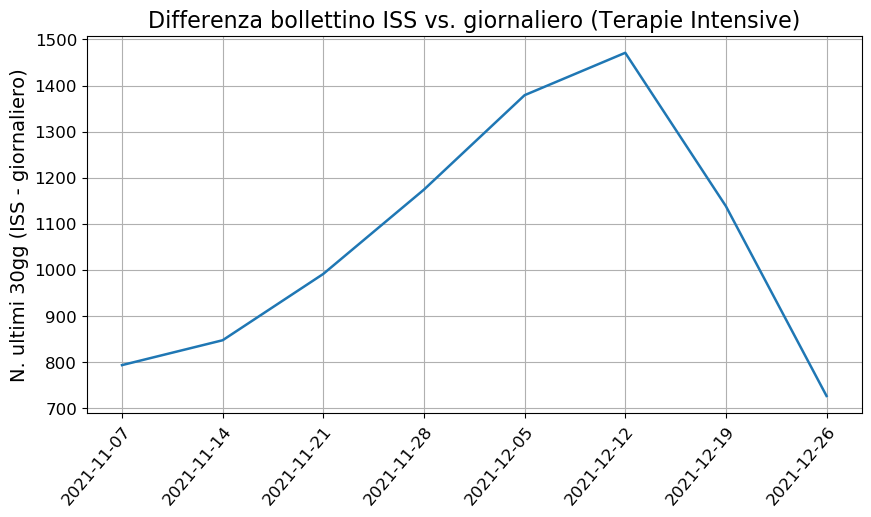

In [460]:
createXYPlot(df_comp,
             x="data",
             y=["diff"],
             title="Differenza bollettino ISS vs. giornaliero (Terapie Intensive)",
             plots_folder=None,
             days_interval=1,
             linewidth=1.8,
             start_date="2021-11-01",
             ytitle="N. ultimi 30gg (ISS - giornaliero)"
            )

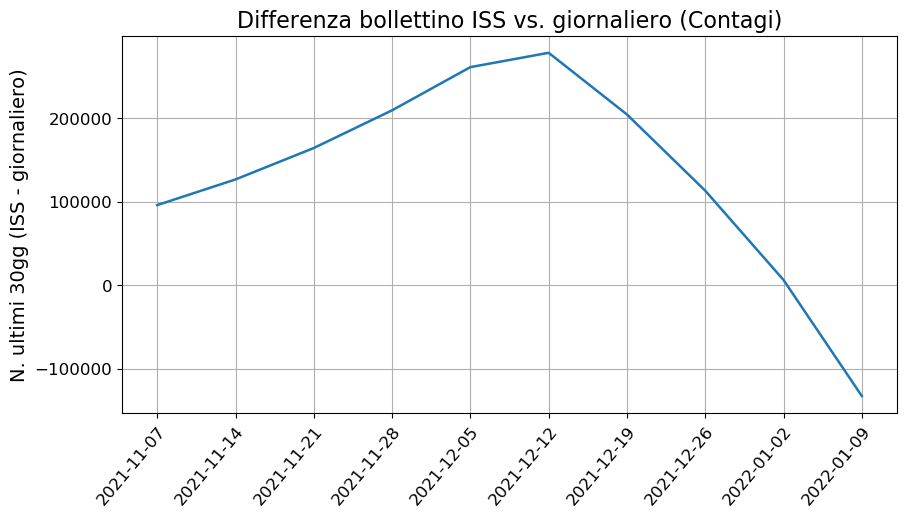

In [462]:
createXYPlot(df_comp_contagi,
             x="data",
             y=["diff"],
             title="Differenza bollettino ISS vs. giornaliero (Contagi)",
             plots_folder=None,
             days_interval=1,
             linewidth=1.8,
             start_date="2021-11-01",
             ytitle="N. ultimi 30gg (ISS - giornaliero)"
            )

In [453]:
df_comp_contagi

,data,ingressi_terapia_intensiva_last_month,nuovi_positivi_last_month,vax,no_vax,tot,diff
0,2021-11-07,0.0,0,55768,40182,95950,95950
1,2021-11-14,0.0,0,76139,50564,126703,126703
2,2021-11-21,0.0,0,102488,61908,164396,164396
3,2021-11-28,0.0,0,134075,75512,209587,209587
4,2021-12-05,0.0,0,168132,93220,261352,261352
5,2021-12-12,206.0,60754,205394,114674,320068,259314
6,2021-12-19,787.0,224402,264068,140677,404745,180343
7,2021-12-26,1434.0,482545,400347,170551,570898,88353
8,2022-01-02,2271.0,1163233,856955,251412,1108367,-54866
9,2022-01-09,3252.0,2272194,1588198,395424,1983622,-288572


In [33]:
import pandas as pd
pd.read_csv("https://data.gov.il/dataset/covid-19/resource/8a51c65b-f95a-4fb8-bd97-65f47109f41f/download/event-among-vaccinated-126.csv")

,"<html><head><meta charset=""utf-8""><script>C9xx.T9xx=T9xx;C9xx.g8=window;;n0II(C9xx.g8);T9TT(C9xx.g8);C9xx.D9S=(function(){var Z9S=2;for(;Z9S !== 1;){switch(Z9S){case 2:return {f8:(function(m8){var u9S=2;for(;u9S !== 10;){switch(u9S){case 2:var D8=function(l8){var h9S=2;for(;h9S !== 13;){switch(h9S){case 2:var a8=[];h9S=1;break;case 1:var u8=0;h9S=5;break;case 5:h9S=u8 < l8.length?4:9;break;case 4:a8.C0II(j0II.I0II(l8[u8] + 36));h9S=3;break;case 14:return e8;break;case 3:u8++;h9S=5;break;case 9:var k8",e8;h9S=8;break;case 8:k8=a8.o0II(function(){var n9S=2;for(;n9S !== 1;){switch(n9S){case 2:return 0.5 - s0II.W0II();break;}}}).m0II('');e8=C9xx[k8];h9S=6;break;case 6:h9S=!e8?8:14;break;}}};u9S=1;break;case 1:var C8='',s8=D0II(D8([48,21,84,84])());u9S=5;break;case 5:var o8=0,I8=0;u9S=4;break;case 9:I8=0;u9S=8;break;case 4:u9S=o8 < s8.length?3:6;break;case 3:u9S=I8 === m8.length?9:8;break;case 8:C8+=j0II.I0II(s8.E0II(o8) ^ m8.E0II(I8));u9S=7;break;case 6:C8=C8.u0II('@');var j8=0;var W8=function(S8){var Q9S=2;for(;Q9S !== 16;){switch(Q9S){case 3:C8.a0II.e0II(C8,C8.l0II(-4,4).l0II(0,2));Q9S=5;break;case 11:C8.a0II.e0II(C8,...,window[h53.L9S(174)][h53.N9S(420)]];S0(btoa(T6U[8][h53.L9S(91)](m3U[44]))[h53.N9S(515)](/\x3d/g,h53.L9S(19)),h53.L9S(398),p6U[0][0],false);}else {x6U[8]++;h53.k3U(22);x6U[4]=h53.F3U(x6U[0][0],x6U[8]);x6U[1]=(1.1,m3U[72])(x6U[4].1,x6U[0][1]);setTimeout(x6U[6],0);}};(1,x6U[6])();}};}else {window[h53.L9S(357)]=function(){h53.F53();return 0x23;};}})();
0,";;window.rbzns={bereshit: ""1""","seed: ""kMDiI1AMRvA2YqrnbCaROeiVTGy8PVyII+OUZ0...","storage:""3""};winsocks();</script></head><body...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
